In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [3]:
!pwd

/root/Internship-Valeo/Project


In [4]:
DATA_PATH = '/root/Internship-Valeo/Project/data'
TMPDIR = '/root/Internship-Valeo/Project/tmp'

In [5]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [6]:
config = {
            'primitives': 'all',
            'truncate': {},
            'validation_size': -1,
            'test_size': -1,
            'on-the-fly': False,
            'cache_in_memory': False,
            'suffix': None,
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'generation': {
                'split_sizes': {'training': 10000, 'validation': 200, 'test': 500},
                'image_size': [960, 1280],
                'random_seed': 0,
                'params': {
                    'generate_background': {
                        'min_kernel_size': 150, 'max_kernel_size': 500,
                        'min_rad_ratio': 0.02, 'max_rad_ratio': 0.031},
                    'draw_stripes': {'transform_params': (0.1, 0.1)},
                    'draw_multiple_polygons': {'kernel_boundaries': (50, 100)}
                },
            },
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': True,
                    'primitives': 'all',
                    'params': {
                        'random_brightness': {'max_abs_change': 75},
                        'random_contrast': {'strength_range': [0.3, 1.8]},
                        'additive_gaussian_noise': {'stddev_range': [0, 15]},
                        'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                        'additive_shade':{
                            'transparency_range': [-0.5, 0.8],
                            'kernel_size_range': [50, 100]},
                        'motion_blur': {'max_kernel_size': 7}},
                    'random_order': True,
                },
                'homographic': {
                    'enable': True,
                    'params': {
                        'translation': True,
                        'rotation': True,
                        'scaling': True,
                        'perspective': True,
                        'scaling_amplitude': 0.2,
                        'perspective_amplitude_x': 0.2,
                        'perspective_amplitude_y': 0.2,
                        'patch_ratio': 0.8,
                        'max_angle': 1.57,  # 3.14
                        'allow_artifacts': True,
                        'translation_overflow': 0.05,
                        'valid_border_margin': 2,
                    },
                    'valid_border_margin': 0,
                },
            }
    }
drawing_primitives = [
            'draw_lines',
            'draw_polygon',
            'draw_multiple_polygons',
            'draw_ellipses',
            'draw_star',
            'draw_checkerboard',
            'draw_stripes',
            'draw_cube',
            'gaussian_noise'
    ]

In [7]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [8]:
def dump_primitive_data(primitive, tar_path, config):
    temp_dir = Path(TMPDIR, primitive)

    synthetic_dataset.set_random_state(np.random.RandomState(
                config['generation']['random_seed']))
    for split, size in config['generation']['split_sizes'].items():
        im_dir, pts_dir = [Path(temp_dir, i, split) for i in ['images', 'points']]
        im_dir.mkdir(parents=True, exist_ok=True)
        pts_dir.mkdir(parents=True, exist_ok=True)

        for i in tqdm(range(size), desc=split, leave=False):
            image = synthetic_dataset.generate_background(
                        config['generation']['image_size'],
                        config['generation']['params']['generate_background'])
            points = np.array(getattr(synthetic_dataset, primitive)(
                        image, config['generation']['params'].get(primitive, {})))
            points = np.flip(points, 1)  # reverse convention with opencv

            b = config['preprocessing']['blur_size']
            image = cv2.GaussianBlur(image, (b, b), 0)
            points = (points * np.array(config['preprocessing']['resize'], np.float)
                          / np.array(config['generation']['image_size'], np.float))
            image = cv2.resize(image, tuple(config['preprocessing']['resize'][::-1]),
                                   interpolation=cv2.INTER_LINEAR)

            cv2.imwrite(str(Path(im_dir, '{}.png'.format(i))), image)
            np.save(Path(pts_dir, '{}.npy'.format(i)), points)

    # Pack into a tar file
    tar = tarfile.open(tar_path, mode='w:gz')
    tar.add(temp_dir, arcname=primitive)
    tar.close()
    shutil.rmtree(temp_dir)

In [9]:
primitives = parse_primitives(config['primitives'], drawing_primitives)
basepath = Path(
                DATA_PATH, 'synthetic_shapes' +
                ('_{}'.format(config['suffix']) if config['suffix'] is not None else ''))
basepath.mkdir(parents=True, exist_ok=True)

splits = {s: {'images': [], 'points': []}
                  for s in ['training', 'validation', 'test']}

In [10]:
# no need to run this again as synthetic shapes have been generated

# for primitive in primitives:
#     tar_path = Path(basepath, '{}.tar.gz'.format(primitive))
#     if not tar_path.exists():
#         dump_primitive_data(primitive, tar_path, config)

In [11]:
for primitive in primitives:
    # Untar locally
#     tar_path = Path(basepath, '{}.tar.gz'.format(primitive))
#     tar = tarfile.open(tar_path)
    temp_dir = Path(TMPDIR)
#     tar.extractall(path=temp_dir)
#     tar.close()
    # Gather filenames in all splits, optionally truncate
    truncate = config['truncate'].get(primitive, 1)
    path = Path(temp_dir, primitive)
    for s in splits:
        e = [str(p) for p in Path(path, 'images', s).iterdir()]
        f = [p.replace('images', 'points') for p in e]
        f = [p.replace('.png', '.npy') for p in f]
        splits[s]['images'].extend(e[:int(truncate*len(e))])
        splits[s]['points'].extend(f[:int(truncate*len(f))])

In [12]:
# Shuffle
for s in splits:
    perm = np.random.RandomState(0).permutation(len(splits[s]['images']))
    for obj in ['images', 'points']:
        splits[s][obj] = np.array(splits[s][obj])[perm].tolist()

In [13]:
len(splits['training']['images']), len(splits['test']['images']), len(splits['validation']['images'])

(90000, 4500, 1800)

In [14]:
# code for photometric augmentation

primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

indices = tf.range(len(primitives_photo))
if config['augmentation']['photometric']['random_order']:
    indices = tf.random.shuffle(indices)
def photo_aug_step(i, image):
    fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
                for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
    image = tf.case(fn_pairs)
    return i + 1, image

In [15]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [16]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001, # 1/65
            'descriptor_size': 256,
            'batch_size': 64,
            'epochs': 25,
            'learning_rate': 0.001,
            'kernel_reg': 0.,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 4,
            'top_k': 0
    }

In [17]:
class SyntheticShapes(keras.utils.Sequence):
    def __init__(self, image_files, point_files, is_training, batch_size = model_config['batch_size']):
        self.__image_files, self.__point_files = image_files, point_files
        self.__batch_size = batch_size
        self.__is_training = is_training
    def __getitem__(self, index):
        images = []
        points_maps = []
        points_list = []
        homography_list = [] # not returned yet
        warped_images = []
        valid_masks = []
        warped_points_list = []
        warped_points_maps = []
        
        
        if (index + 1)*self.__batch_size > len(self.__image_files):
            self.__batch_size = len(self.__image_files) - index * self.__batch_size
            
        batch_img_files = self.__image_files[index * self.__batch_size:(index + 1) * self.__batch_size]
        batch_point_files = self.__point_files[index * self.__batch_size:(index + 1) * self.__batch_size]
        
        for img_file, point_file, itr in zip(batch_img_files, batch_point_files, range(self.__batch_size)):

            image = cv2.imread(img_file, 0)
            image = np.expand_dims(image, axis = 2)
            image_shape = tf.shape(image)[:2]
            points = _read_points(point_file)
            points = np.round(points).astype(int)
            
            if self.__is_training:
                # add photometric_augmentation
                _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
                                 photo_aug_step, [0, image], parallel_iterations=1)              
                
                # add homography
                homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
                warped_image = H_transform(image, homography, interpolation='BILINEAR')
                valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
                warped_points = warp_points(points, homography)
                warped_points = filter_points(warped_points, image_shape)
                warped_points = np.round(warped_points).astype(int)
                
                warped_kp = tf.minimum(warped_points, image_shape-1)
                warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
                                                                     dtype=tf.int32), image_shape)
                        
                homography_list.append(homography)
                warped_image = warped_image / 255.0
                warped_images.append(warped_image)
                valid_masks.append(valid_mask)
                warped_points_list.append(warped_points)
                warped_points_maps.append(warped_points_map)

            kp = tf.minimum(points, image_shape-1)
            points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
            image = image / 255.0
            images.append(image)
            points_maps.append(points_map)
            points_list.append(points)
            
            
        images = np.array(images)
        points_maps = np.expand_dims(points_maps, axis = 3)
        
        if self.__is_training:
            warped_images = np.array(warped_images)
            warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
            valid_masks = np.array(valid_masks)
            dummy_loss_target = np.zeros(self.__batch_size)

            return [warped_images, valid_masks, warped_points_maps], [dummy_loss_target]
        
        else:
            return images, points_maps   
           
    def __len__(self):
        return int(np.ceil(len(self.__image_files) / float(self.__batch_size)))
    
    def on_epoch_end(self):
        pass

In [18]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [19]:
def shared_encoder(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return conv8

In [20]:
def detector_head(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

    prob = tf.nn.softmax(x, axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
    prob = tf.nn.depth_to_space(
              prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob = tf.squeeze(prob, axis=cindex)
    return {'logits': x, 'prob': prob}

In [21]:
def detector_loss(keypoint_map, logits, model_config, valid_mask=None):
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
    valid_mask = tf.cast(valid_mask, tf.float32)
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.cast(valid_mask, tf.int64)
    labels = labels * valid_mask
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    return loss

In [22]:
def model_metrics(y_true, y_pred):
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    y_pred = tf.nn.softmax(y_pred, axis=cindex)
    y_pred = tf.argmax(y_pred, axis =cindex)
  
    y_pred = tf.one_hot(y_pred, depth = 1+pow(model_config['grid_size'], 2))
  
    y_true = tf.nn.space_to_depth(y_true, model_config['grid_size'])
    y_true = tf.cast(y_true, tf.float32)
    # Strip the extra “no interest point” dustbin
    y_pred = y_pred[:, :-1, :, :] if cfirst else y_pred[:, :, :, :-1]
   
    precision = tf.math.reduce_sum(y_pred * y_true) /tf.math.reduce_sum(y_pred)
    recall = tf.math.reduce_sum(y_pred * y_true) / tf.math.reduce_sum(y_true)
#     return {'precision': precision, 'recall': recall}
    return precision

In [23]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1], model_config = model_config, valid_mask = inputs[2])
        metrics = self.metrics_fn(inputs[0], inputs[1])
        self.add_loss(tf.math.reduce_mean(loss))
        self.add_metric(metrics, name = 'precision')
        return loss

def net(input_shape = (240, 320, 1)):
    images_inputs = Input(shape = input_shape, name = 'images')
    valid_masks_inputs = Input(shape = input_shape, name = 'valid masks')
    warped_points_inputs = Input(shape = input_shape, name = 'warped_points')
    
    encoder_output = shared_encoder(images_inputs, model_config=model_config)
    output = detector_head(encoder_output, model_config=model_config)
    
    loss_layer = DetectorLossLayer()([warped_points_inputs, output['logits'], valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [24]:
model = net(input_shape = (240, 320, 1))

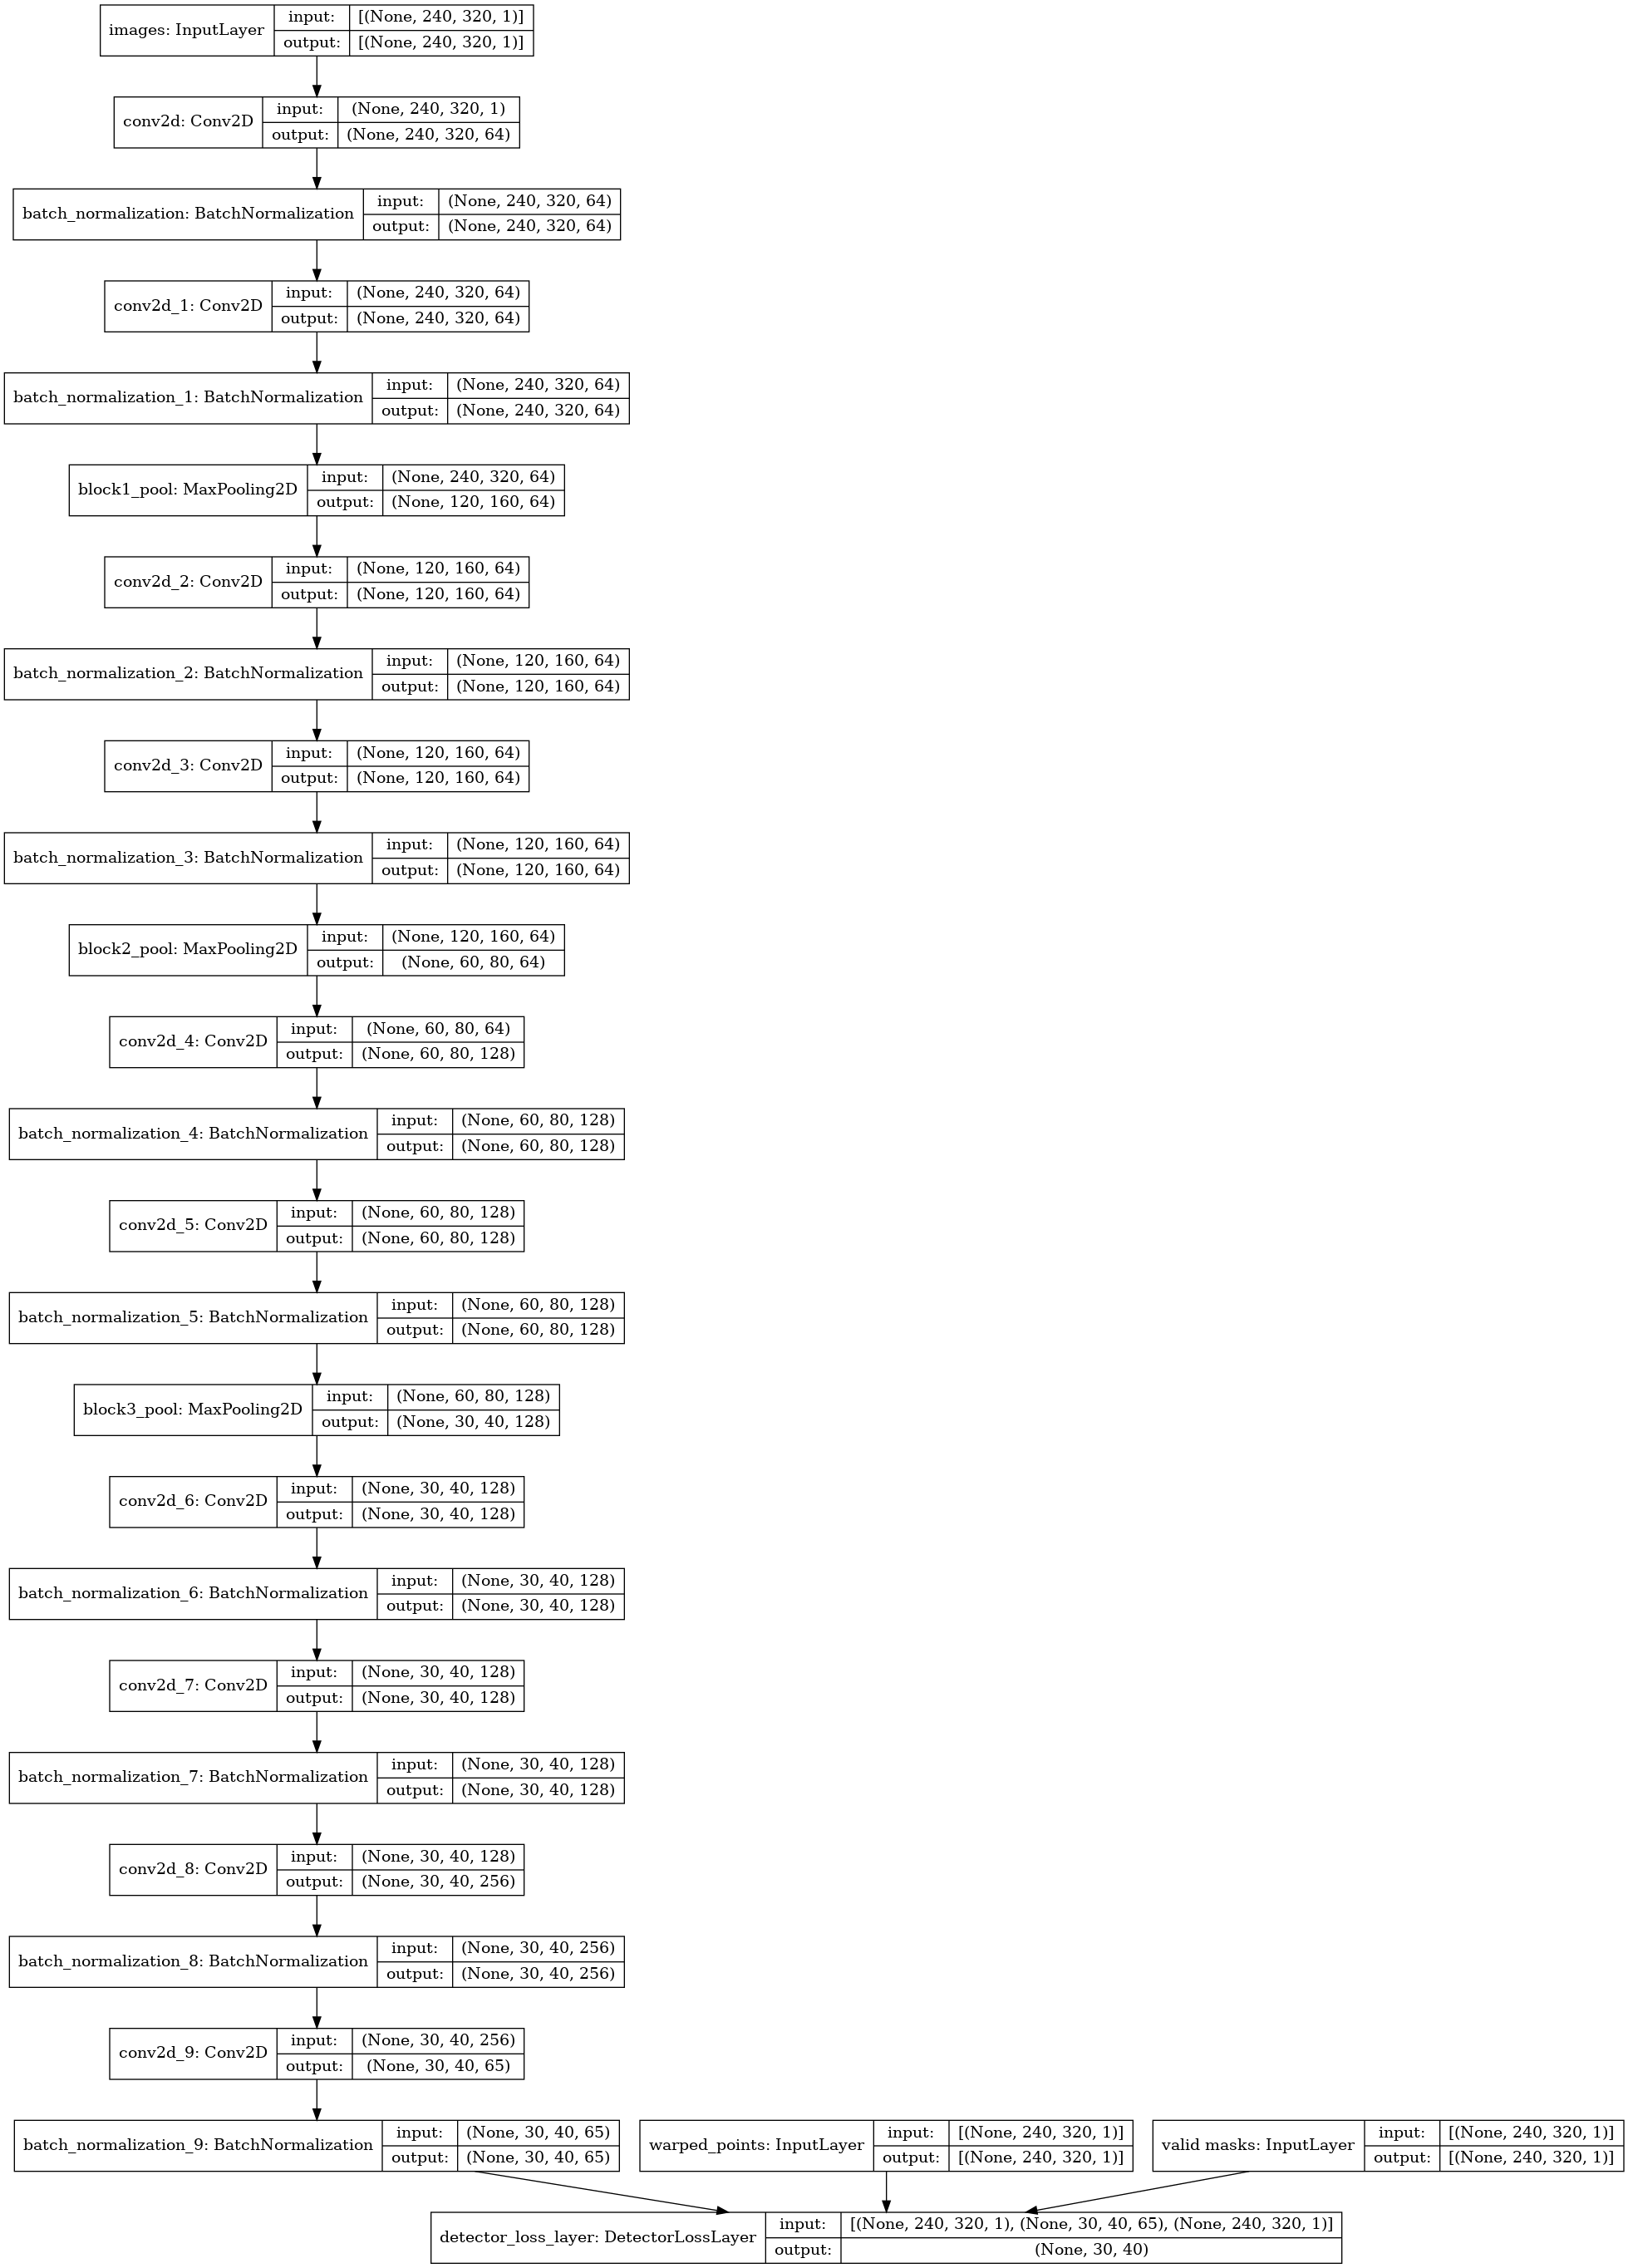

In [25]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [26]:
def dummy_loss(dummy_target, y_pred):
    return tf.squeeze(y_pred)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
              loss = dummy_loss)

In [ ]:
batch_size = model_config['batch_size']

train_gen = SyntheticShapes(splits['training']['images'], splits['training']['points'], 
                                           batch_size = batch_size, is_training = True)

val_gen = SyntheticShapes(splits['validation']['images'], splits['validation']['points'], 
                                         batch_size = batch_size, is_training = False)

train_steps =  len(splits['training']['images'])/batch_size

history = model.fit(train_gen , validation_data = val_gen, steps_per_epoch = train_steps, 
                    epochs=model_config['epochs'], callbacks=[tensorboard_callback])

Epoch 1/25
 243/1406 [====>.........................] - ETA: 1:21:12 - loss: 6.1755 - precision: 8.8159e-05

In [ ]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

In [ ]:
x, y = train_gen.__getitem__(0)

In [ ]:
plt.imshow(x[0], cmap = 'gray')

In [ ]:
plt.imshow(y[0],cmap = 'gray')

In [ ]:
test_gen = SyntheticShapes(splits['test']['images'], splits['test']['points'], 
                           batch_size = model_config['batch_size'], is_training = True)

In [ ]:
x, y = test_gen.__getitem__(1)

In [ ]:
plt.imshow(x[1], cmap = 'gray')

In [ ]:
plt.imshow(y[1], cmap='gray')

In [ ]:
result = model.predict(x)

In [ ]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel
labels = tf.argmax(result, axis =cindex)
one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
# Strip the extra “no interest point” dustbin
one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
one_hot = tf.squeeze(one_hot, axis=cindex)

plt.imshow((one_hot)[0], cmap = 'gray')

In [ ]:
model_metrics(y, result)